# Notebook 05 — Sequence Models (LSTM / GRU)

## Step 1 — Title, imports, paths, and global config

In [18]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

pd.set_option("display.max_columns", 120)
pd.set_option("display.width", 180)
sns.set(style="whitegrid")

RANDOM_SEED = 42

PATIENT_COL = "Patient_ID"
TIME_COL = "ICULOS"
TARGET_COL = "SepsisLabel"
LABEL_COL = "Label_6h"

SEQ_LEN = 24         # hours of history used per sequence sample
BATCH_SIZE = 256
LR = 1e-3
N_EPOCHS = 20
HIDDEN_SIZE = 64
N_LAYERS = 1
DROPOUT = 0.1

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", DEVICE)


def find_project_root() -> Path:
    cur = Path.cwd().resolve()
    for candidate in [cur, *cur.parents]:
        if (candidate / "notebooks").exists() and (candidate / "reports").exists():
            return candidate
    return cur


PROJECT_ROOT = find_project_root()
REPORTS_ROOT = PROJECT_ROOT / "reports"

RESULTS_LABELING = REPORTS_ROOT / "results" / "02_labeling_eda"
RESULTS_XGB = REPORTS_ROOT / "results" / "04_time_window_boosting"
RESULTS_THIS = REPORTS_ROOT / "results" / "05_sequence_models"
FIGURES_THIS = REPORTS_ROOT / "figures" / "05_sequence_models"

RESULTS_THIS.mkdir(parents=True, exist_ok=True)
FIGURES_THIS.mkdir(parents=True, exist_ok=True)

EXPORTED_FIGURES: list[tuple[str, plt.Figure]] = []

print("cwd:", Path.cwd())
print("PROJECT_ROOT:", PROJECT_ROOT)
print("Labeling results dir:", RESULTS_LABELING)
print("XGB results dir    :", RESULTS_XGB)
print("This notebook results dir:", RESULTS_THIS)
print("This notebook figures dir:", FIGURES_THIS)

Using device: cpu
cwd: C:\Users\marta\PyCharmMiscProject\sepsis-predictor\notebooks
PROJECT_ROOT: C:\Users\marta\PyCharmMiscProject\sepsis-predictor
Labeling results dir: C:\Users\marta\PyCharmMiscProject\sepsis-predictor\reports\results\02_labeling_eda
XGB results dir    : C:\Users\marta\PyCharmMiscProject\sepsis-predictor\reports\results\04_time_window_boosting
This notebook results dir: C:\Users\marta\PyCharmMiscProject\sepsis-predictor\reports\results\05_sequence_models
This notebook figures dir: C:\Users\marta\PyCharmMiscProject\sepsis-predictor\reports\figures\05_sequence_models


## Step 2 — Load data and use consistent patient splits

In [19]:
# 6h-labeled tables from Notebook 02
train_path = RESULTS_LABELING / "02_labeling_eda_train.csv"
test_path = RESULTS_LABELING / "02_labeling_eda_test.csv"

print("Loading labeled datasets from:")
print("  train:", train_path)
print("  test :", test_path)

assert train_path.exists(), f"Missing file: {train_path}"
assert test_path.exists(), f"Missing file: {test_path}"

train_df = pd.read_csv(train_path, low_memory=False)
test_df = pd.read_csv(test_path, low_memory=False)

for name, df in [("train_df", train_df), ("test_df", test_df)]:
    assert df.columns.is_unique, f"Duplicate column names in {name}"

print("\nLoaded datasets:")
print("  train_df:", train_df.shape)
print("  test_df :", test_df.shape)
display(train_df.head())

# %%
# Risk trajectories from Notebook 04 contain the patient split flags
trainval_traj_path = RESULTS_XGB / "04_xgb_risk_trajectories_trainval.csv"
test_traj_path = RESULTS_XGB / "04_xgb_risk_trajectories_test.csv"

print("\nLoading XGB trajectories (for patient splits) from:")
print("  train/val:", trainval_traj_path)
print("  test     :", test_traj_path)

assert trainval_traj_path.exists(), f"Missing file: {trainval_traj_path}"
assert test_traj_path.exists(), f"Missing file: {test_traj_path}"

trainval_traj = pd.read_csv(trainval_traj_path)
test_traj = pd.read_csv(test_traj_path)

# Check required columns
for name, df in [("trainval_traj", trainval_traj), ("test_traj", test_traj)]:
    for col in [PATIENT_COL, TIME_COL, "split_04"]:
        assert col in df.columns, f"{col} missing in {name}"

print("\nTrajectory shapes:")
print("  trainval_traj:", trainval_traj.shape)
print("  test_traj    :", test_traj.shape)

# %%
# Derive patient-level splits from split_04 column
train_patients_05 = (
    trainval_traj.loc[trainval_traj["split_04"] == "train", PATIENT_COL]
    .drop_duplicates()
    .values
)
val_patients_05 = (
    trainval_traj.loc[trainval_traj["split_04"] == "val", PATIENT_COL]
    .drop_duplicates()
    .values
)
test_patients_05 = (
    test_traj[PATIENT_COL].drop_duplicates().values
)

print("\nPatient counts (sequence notebook splits):")
print("  train patients:", len(train_patients_05))
print("  val patients  :", len(val_patients_05))
print("  test patients :", len(test_patients_05))

Loading labeled datasets from:
  train: C:\Users\marta\PyCharmMiscProject\sepsis-predictor\reports\results\02_labeling_eda\02_labeling_eda_train.csv
  test : C:\Users\marta\PyCharmMiscProject\sepsis-predictor\reports\results\02_labeling_eda\02_labeling_eda_test.csv

Loaded datasets:
  train_df: (1220925, 19)
  test_df : (306301, 19)


,Hour,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,Glucose,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel,Patient_ID,sepsis_onset_time,Label_6h
0,-0.981406,0.738859,-0.890076,-1.095866,-1.132851,-0.464943,-0.139349,0.068645,1.46577,1.318117,-1.127442,-0.655941,0.655941,0.482756,1,0,1,NaN,0
1,-0.942007,0.738859,-0.890076,-1.095866,-1.132851,-0.464943,-0.139349,0.068645,1.46577,1.318117,-1.127442,-0.655941,0.655941,0.482756,2,0,1,NaN,0
2,-0.902609,0.269532,0.700883,-1.095866,-0.070135,0.216319,-0.139349,0.684351,1.46577,1.318117,-1.127442,-0.655941,0.655941,0.482756,3,0,1,NaN,0
3,-0.863210,0.328198,-0.890076,-1.095866,-0.070135,0.216319,-0.139349,2.326236,1.46577,1.318117,-1.127442,-0.655941,0.655941,0.482756,4,0,1,NaN,0
4,-0.823812,1.090853,-3.276514,-1.095866,-0.070135,0.556631,-0.139349,1.197440,1.46577,1.318117,-1.127442,-0.655941,0.655941,0.482756,5,0,1,NaN,0



Loading XGB trajectories (for patient splits) from:
  train/val: C:\Users\marta\PyCharmMiscProject\sepsis-predictor\reports\results\04_time_window_boosting\04_xgb_risk_trajectories_trainval.csv
  test     : C:\Users\marta\PyCharmMiscProject\sepsis-predictor\reports\results\04_time_window_boosting\04_xgb_risk_trajectories_test.csv

Trajectory shapes:
  trainval_traj: (872075, 6)
  test_traj    : (218991, 6)

Patient counts (sequence notebook splits):
  train patients: 24879
  val patients  : 6220
  test patients : 7787


## Step 3 — Define feature set for sequence models

In [20]:
EXCLUDE_SEQ_COLS = {
    PATIENT_COL,
    TIME_COL,
    TARGET_COL,
    LABEL_COL,
    "sepsis_onset_time",
}

seq_feature_cols = [
    c for c in train_df.columns
    if c not in EXCLUDE_SEQ_COLS and pd.api.types.is_numeric_dtype(train_df[c])
]

print(f"Number of sequence feature columns: {len(seq_feature_cols)}")
print("Sample sequence features:", seq_feature_cols[:12])

Number of sequence feature columns: 14
Sample sequence features: ['Hour', 'HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'Glucose', 'Age', 'Gender', 'Unit1']


## Step 4 — Normalization (fit on training patients only)

In [21]:
# Tag which split each row belongs to, based on patient IDs from Step 2
def assign_split(df: pd.DataFrame) -> pd.DataFrame:
    df_out = df.copy()
    df_out["split_05"] = "other"
    df_out.loc[df_out[PATIENT_COL].isin(train_patients_05), "split_05"] = "train"
    df_out.loc[df_out[PATIENT_COL].isin(val_patients_05), "split_05"] = "val"
    df_out.loc[df_out[PATIENT_COL].isin(test_patients_05), "split_05"] = "test"
    return df_out


train_df = assign_split(train_df)
test_df = assign_split(test_df)

print(train_df["split_05"].value_counts())
print(test_df["split_05"].value_counts())

# %%
# Concatenate all rows from training patients (may be spread across train_df/test_df)
train_pat_mask = train_df["split_05"] == "train"
train_core = train_df.loc[train_pat_mask, seq_feature_cols]

print("\nRows used to fit normalization (train patients only):", train_core.shape[0])

feat_mean = train_core.mean(axis=0)
feat_std = train_core.std(axis=0).replace(0, 1.0)  # avoid division by zero

# Apply normalization to both tables
def apply_normalization(df: pd.DataFrame) -> pd.DataFrame:
    df_out = df.copy()
    df_out[seq_feature_cols] = (df_out[seq_feature_cols] - feat_mean) / feat_std
    return df_out


train_df_norm = apply_normalization(train_df)
test_df_norm = apply_normalization(test_df)

print("\nAfter normalization:")
display(train_df_norm[seq_feature_cols].iloc[:3, :10])

split_05
train    972834
val      241330
other      6761
Name: count, dtype: int64
split_05
test     304648
other      1653
Name: count, dtype: int64

Rows used to fit normalization (train patients only): 972834

After normalization:


,Hour,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,Glucose,Age
0,-1.002378,0.745499,-0.895624,-1.098887,-1.133968,-0.465837,-0.137663,0.072016,1.46988,1.318954
1,-0.961686,0.745499,-0.895624,-1.098887,-1.133968,-0.465837,-0.137663,0.072016,1.46988,1.318954
2,-0.920994,0.274130,0.702687,-1.098887,-0.069531,0.216474,-0.137663,0.689599,1.46988,1.318954


## Step 5 — Build per-patient sequences + label positions

In [22]:
# Combine normalized tables so we can group by patient across both
all_df_norm = pd.concat([train_df_norm, test_df_norm], axis=0, ignore_index=True)

# Keep only rows that belong to one of the three splits
valid_mask = all_df_norm["split_05"].isin(["train", "val", "test"])
all_df_norm = all_df_norm.loc[valid_mask].copy()

# Sort per patient and time, add hour_index per patient (for sanity)
all_df_norm.sort_values([PATIENT_COL, TIME_COL], inplace=True)
all_df_norm["hour_index"] = all_df_norm.groupby(PATIENT_COL).cumcount()

print("Combined normalized frame:")
print(all_df_norm.shape)
display(all_df_norm[[PATIENT_COL, TIME_COL, "split_05"]].head())


def build_patient_data(df: pd.DataFrame):
    """
    Create a dictionary: patient_id -> dict(features, labels, times).
    Features = normalized seq_feature_cols.
    Labels   = Label_6h (0/1).
    Times    = ICULOS (for later risk trajectories).
    """
    patient_data = {}
    for pid, sub in df.groupby(PATIENT_COL):
        sub_sorted = sub.sort_values(TIME_COL)
        feats = sub_sorted[seq_feature_cols].to_numpy(dtype=np.float32)
        labels = sub_sorted[LABEL_COL].to_numpy(dtype=np.float32)
        times = sub_sorted[TIME_COL].to_numpy(dtype=np.int32)
        patient_data[pid] = {
            "features": feats,
            "labels": labels,
            "times": times,
        }
    return patient_data


patient_data = build_patient_data(all_df_norm)

print("\nNumber of patients in patient_data:", len(patient_data))


def build_sequence_index(
    patient_ids: np.ndarray,
    patient_data: dict,
    seq_len: int,
) -> list[tuple[int, int]]:
    """
    For each patient in patient_ids, generate all valid sequence endpoints.
    Each sample is (patient_id, end_idx) where:
      - end_idx >= seq_len - 1
      - label at end_idx is 0 or 1
    """
    index = []
    for pid in patient_ids:
        data = patient_data.get(pid)
        if data is None:
            continue
        labels = data["labels"]
        T = len(labels)
        if T < seq_len:
            continue
        for end in range(seq_len - 1, T):
            lab = labels[end]
            if np.isnan(lab):
                continue
            index.append((pid, end))
    return index


train_index = build_sequence_index(train_patients_05, patient_data, SEQ_LEN)
val_index = build_sequence_index(val_patients_05, patient_data, SEQ_LEN)
test_index = build_sequence_index(test_patients_05, patient_data, SEQ_LEN)

print("\nNumber of sequence samples:")
print("  train:", len(train_index))
print("  val  :", len(val_index))
print("  test :", len(test_index))


def sequence_label_stats(index, patient_data):
    labels = []
    for pid, end in index:
        labels.append(patient_data[pid]["labels"][end])
    labels = np.array(labels, dtype=np.int64)
    unique, counts = np.unique(labels, return_counts=True)
    freq = dict(zip(unique, counts))
    total = len(labels)
    pos = freq.get(1, 0)
    return total, pos, pos / total if total > 0 else 0.0


train_total, train_pos, train_rate = sequence_label_stats(train_index, patient_data)
val_total, val_pos, val_rate = sequence_label_stats(val_index, patient_data)
test_total, test_pos, test_rate = sequence_label_stats(test_index, patient_data)

print("\nSequence-level Label_6h prevalence:")
print(f"  TRAIN: n={train_total}, positives={train_pos} ({train_rate:.3%})")
print(f"  VAL  : n={val_total}, positives={val_pos} ({val_rate:.3%})")
print(f"  TEST : n={test_total}, positives={test_pos} ({test_rate:.3%})")

Combined normalized frame:
(1518812, 21)


,Patient_ID,ICULOS,split_05
0,1,1,train
1,1,2,train
2,1,3,train
3,1,4,train
4,1,5,train



Number of patients in patient_data: 38886

Number of sequence samples:
  train: 423721
  val  : 104100
  test : 132591

Sequence-level Label_6h prevalence:
  TRAIN: n=423721, positives=5889 (1.390%)
  VAL  : n=104100, positives=1405 (1.350%)
  TEST : n=132591, positives=1722 (1.299%)


## Step 6 — PyTorch Dataset and DataLoader

In [23]:
class SepsisSequenceDataset(Dataset):
    def __init__(
        self,
        index: list[tuple[int, int]],
        patient_data: dict,
        seq_feature_cols: list[str],
        seq_len: int,
    ):
        self.index = index
        self.patient_data = patient_data
        self.seq_len = seq_len
        self.n_features = len(seq_feature_cols)

    def __len__(self) -> int:
        return len(self.index)

    def __getitem__(self, i: int):
        pid, end_idx = self.index[i]
        data = self.patient_data[pid]
        feats = data["features"]
        labels = data["labels"]

        start_idx = end_idx - self.seq_len + 1
        x_seq = feats[start_idx : end_idx + 1]   # shape (seq_len, n_features)
        y = labels[end_idx]                     # scalar 0/1

        x_tensor = torch.from_numpy(x_seq)               # (L, F)
        y_tensor = torch.tensor(y, dtype=torch.float32)  # ()

        return x_tensor, y_tensor


train_dataset = SepsisSequenceDataset(train_index, patient_data, seq_feature_cols, SEQ_LEN)
val_dataset = SepsisSequenceDataset(val_index, patient_data, seq_feature_cols, SEQ_LEN)
test_dataset = SepsisSequenceDataset(test_index, patient_data, seq_feature_cols, SEQ_LEN)

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,
    pin_memory=(DEVICE == "cuda"),
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=(DEVICE == "cuda"),
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=(DEVICE == "cuda"),
)

print("Dataset sizes (batches will be smaller due to shuffling):")
print("  train sequences:", len(train_dataset))
print("  val sequences  :", len(val_dataset))
print("  test sequences :", len(test_dataset))


Dataset sizes (batches will be smaller due to shuffling):
  train sequences: 423721
  val sequences  : 104100
  test sequences : 132591


## Step 7 — Define GRU-based sequence model

In [24]:
class GRUSepsisModel(nn.Module):
    def __init__(self, n_features: int, hidden_size: int, n_layers: int, dropout: float):
        super().__init__()
        self.gru = nn.GRU(
            input_size=n_features,
            hidden_size=hidden_size,
            num_layers=n_layers,
            batch_first=True,
            dropout=dropout if n_layers > 1 else 0.0,
        )
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        # x: (batch, seq_len, n_features)
        out, h_n = self.gru(x)
        # Use the last hidden state from the top GRU layer
        last_hidden = h_n[-1]  # (batch, hidden_size)
        logits = self.fc(last_hidden).squeeze(-1)  # (batch,)
        return logits


n_features = len(seq_feature_cols)
print("Number of input features:", n_features)

torch.manual_seed(RANDOM_SEED)
model = GRUSepsisModel(
    n_features=n_features,
    hidden_size=HIDDEN_SIZE,
    n_layers=N_LAYERS,
    dropout=DROPOUT,
).to(DEVICE)

print(model)

Number of input features: 14
GRUSepsisModel(
  (gru): GRU(14, 64, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)


## Step 8 — Train GRU with class imbalance handling and validation monitoring

In [25]:
# (Re)define GRU with the tuned hyperparameters
SEQ_LEN = 24
BATCH_SIZE = 256
LR = 3e-4
N_EPOCHS = 40
HIDDEN_SIZE = 64
N_LAYERS = 1
DROPOUT = 0.1

torch.manual_seed(RANDOM_SEED)
model = GRUSepsisModel(
    n_features=len(seq_feature_cols),
    hidden_size=HIDDEN_SIZE,
    n_layers=N_LAYERS,
    dropout=DROPOUT,
).to(DEVICE)

In [26]:
# Compute class imbalance from train_index
train_total, train_pos, train_rate = sequence_label_stats(train_index, patient_data)
n_pos = train_pos
n_neg = train_total - train_pos
raw_ratio = n_neg / n_pos

# Use softened pos_weight
pos_weight_value = np.sqrt(raw_ratio)    # ~8.4 for ratio ~71
print(f"GRU raw neg/pos ratio ≈ {raw_ratio:.1f}, using pos_weight ≈ {pos_weight_value:.2f}")

criterion = nn.BCEWithLogitsLoss(
    pos_weight=torch.tensor(pos_weight_value, dtype=torch.float32, device=DEVICE)
)

optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=5e-5)

# --- LR scheduler with warmup ---
warmup_epochs = 8          # small LR at the beginning → gradual improvements
min_lr_factor = 0.2        # start at 20% of LR and ramp to 100%

def lr_lambda(epoch: int):
    # epoch is 0-based here
    if epoch < warmup_epochs:
        # linearly scale from min_lr_factor to 1.0 over warmup_epochs
        return min_lr_factor + (1.0 - min_lr_factor) * (epoch + 1) / warmup_epochs
    else:
        # after warmup keep LR constant; you could add decay here if you want
        return 1.0

scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda)


def run_epoch(model, loader, train: bool):
    if train:
        model.train()
    else:
        model.eval()

    total_loss = 0.0
    all_probs = []
    all_targets = []

    for x_batch, y_batch in loader:
        x_batch = x_batch.to(DEVICE)
        y_batch = y_batch.to(DEVICE)

        if train:
            optimizer.zero_grad()

        logits = model(x_batch)
        loss = criterion(logits, y_batch)

        if train:
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
            optimizer.step()

        total_loss += loss.item() * x_batch.size(0)

        probs = torch.sigmoid(logits).detach().cpu().numpy()
        targets = y_batch.detach().cpu().numpy()

        all_probs.append(probs)
        all_targets.append(targets)

    total = len(loader.dataset)
    avg_loss = total_loss / max(total, 1)

    all_probs = np.concatenate(all_probs) if all_probs else np.array([])
    all_targets = np.concatenate(all_targets) if all_targets else np.array([])

    if total > 0:
        auroc = metrics.roc_auc_score(all_targets, all_probs)
        auprc = metrics.average_precision_score(all_targets, all_probs)
        preds = (all_probs >= 0.5).astype(int)
        f1 = metrics.f1_score(all_targets, preds)
        acc = metrics.accuracy_score(all_targets, preds)
    else:
        auroc = auprc = f1 = acc = np.nan

    return avg_loss, auroc, auprc, f1, acc


best_val_auprc_ema = -np.inf
best_state = None
history = []

patience = 8
min_delta = 1e-4
epochs_no_improve = 0

alpha_ema = 0.3
val_auprc_ema = None

for epoch in range(1, N_EPOCHS + 1):
    current_lr = optimizer.param_groups[0]["lr"]
    print(f"\nEpoch {epoch:02d} — LR = {current_lr:.6f}")

    train_loss, train_auroc, train_auprc, train_f1, train_acc = run_epoch(
        model, train_loader, train=True
    )
    val_loss, val_auroc, val_auprc, val_f1, val_acc = run_epoch(
        model, val_loader, train=False
    )

    # Step scheduler AFTER epoch
    scheduler.step()

    # Update EMA of validation AUPRC
    if val_auprc_ema is None:
        val_auprc_ema = val_auprc
    else:
        val_auprc_ema = alpha_ema * val_auprc + (1 - alpha_ema) * val_auprc_ema

    history.append({
        "epoch": epoch,
        "lr": current_lr,
        "train_loss": train_loss,
        "val_loss": val_loss,
        "val_auroc": val_auroc,
        "val_auprc_raw": val_auprc,
        "val_auprc_ema": val_auprc_ema,
    })

    print(
        f"train_loss={train_loss:.4f}  val_loss={val_loss:.4f}  "
        f"val_AUROC={val_auroc:.4f}  "
        f"val_AUPRC_raw={val_auprc:.4f}  val_AUPRC_EMA={val_auprc_ema:.4f}"
    )

    # Early stopping on EMA of val AUPRC
    if val_auprc_ema > best_val_auprc_ema + min_delta:
        best_val_auprc_ema = val_auprc_ema
        best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
        epochs_no_improve = 0
        print(f"  → New best model (val AUPRC_EMA = {val_auprc_ema:.4f})")
    else:
        epochs_no_improve += 1
        print(f"  (no EMA improvement for {epochs_no_improve} epochs)")
        if epochs_no_improve >= patience:
            print(f"\nEarly stopping triggered at epoch {epoch} "
                  f"(no val AUPRC_EMA improvement for {patience} epochs).")
            break

# Restore best model
if best_state is not None:
    model.load_state_dict(best_state)
    model.to(DEVICE)
    print(f"\nLoaded best GRU model with best val AUPRC_EMA = {best_val_auprc_ema:.4f}")
else:
    print("\nWarning: no best_state captured.")

GRU raw neg/pos ratio ≈ 71.0, using pos_weight ≈ 8.42

Epoch 01 — LR = 0.000090
train_loss=0.3650  val_loss=0.3054  val_AUROC=0.7791  val_AUPRC_raw=0.0534  val_AUPRC_EMA=0.0534
  → New best model (val AUPRC_EMA = 0.0534)

Epoch 02 — LR = 0.000120
train_loss=0.2979  val_loss=0.3000  val_AUROC=0.7869  val_AUPRC_raw=0.0671  val_AUPRC_EMA=0.0575
  → New best model (val AUPRC_EMA = 0.0575)

Epoch 03 — LR = 0.000150
train_loss=0.2951  val_loss=0.2985  val_AUROC=0.7888  val_AUPRC_raw=0.0803  val_AUPRC_EMA=0.0643
  → New best model (val AUPRC_EMA = 0.0643)

Epoch 04 — LR = 0.000180
train_loss=0.2930  val_loss=0.2981  val_AUROC=0.7910  val_AUPRC_raw=0.0789  val_AUPRC_EMA=0.0687
  → New best model (val AUPRC_EMA = 0.0687)

Epoch 05 — LR = 0.000210
train_loss=0.2915  val_loss=0.2969  val_AUROC=0.7976  val_AUPRC_raw=0.0731  val_AUPRC_EMA=0.0700
  → New best model (val AUPRC_EMA = 0.0700)

Epoch 06 — LR = 0.000240
train_loss=0.2897  val_loss=0.3002  val_AUROC=0.7992  val_AUPRC_raw=0.0746  val_AUPRC

## Step 9 — Final evaluation and ROC/PR curves (GRU)


[VAL — GRU]
loss : 0.2977
AUROC: 0.7957
AUPRC: 0.0722
F1   : 0.0804
ACC  : 0.9820

[TEST — GRU]
loss : 0.2846
AUROC: 0.8141
AUPRC: 0.0619
F1   : 0.0611
ACC  : 0.9812


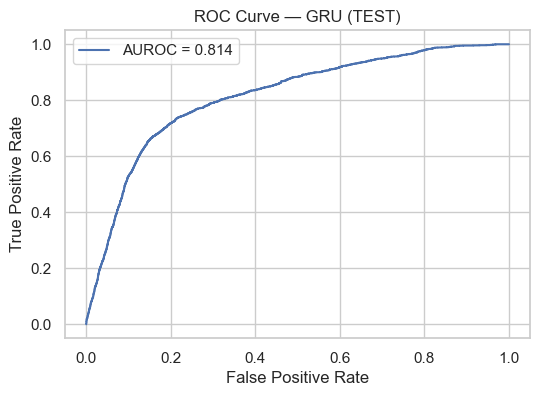

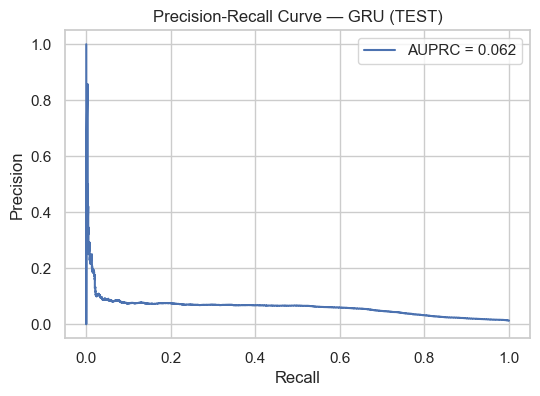

In [27]:
# Helper for getting probabilities + targets
def predict_loader(model, loader):
    model.eval()
    all_probs = []
    all_targets = []
    with torch.no_grad():
        for x_batch, y_batch in loader:
            x_batch = x_batch.to(DEVICE)
            logits = model(x_batch)
            probs = torch.sigmoid(logits).cpu().numpy()
            all_probs.append(probs)
            all_targets.append(y_batch.numpy())
    if not all_probs:
        return np.array([]), np.array([])
    return np.concatenate(all_probs), np.concatenate(all_targets)


# Evaluate on VAL and TEST
val_loss, val_auroc, val_auprc, val_f1, val_acc = run_epoch(model, val_loader, train=False)
test_loss, test_auroc, test_auprc, test_f1, test_acc = run_epoch(model, test_loader, train=False)

print("\n[VAL — GRU]")
print(f"loss : {val_loss:.4f}")
print(f"AUROC: {val_auroc:.4f}")
print(f"AUPRC: {val_auprc:.4f}")
print(f"F1   : {val_f1:.4f}")
print(f"ACC  : {val_acc:.4f}")

print("\n[TEST — GRU]")
print(f"loss : {test_loss:.4f}")
print(f"AUROC: {test_auroc:.4f}")
print(f"AUPRC: {test_auprc:.4f}")
print(f"F1   : {test_f1:.4f}")
print(f"ACC  : {test_acc:.4f}")

# Store GRU metrics for later comparison
gru_val_loss, gru_val_auroc, gru_val_auprc, gru_val_f1, gru_val_acc = (
    val_loss, val_auroc, val_auprc, val_f1, val_acc
)
gru_test_loss, gru_test_auroc, gru_test_auprc, gru_test_f1, gru_test_acc = (
    test_loss, test_auroc, test_auprc, test_f1, test_acc
)

# Probabilities for plots / trajectories
test_probs, test_targets = predict_loader(model, test_loader)

# --- ROC curve (TEST, GRU) ---
fig, ax = plt.subplots(figsize=(6, 4))
fpr, tpr, _ = metrics.roc_curve(test_targets, test_probs)
ax.plot(fpr, tpr, label=f"AUROC = {test_auroc:.3f}")
ax.set_title("ROC Curve — GRU (TEST)")
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.legend()
EXPORTED_FIGURES.append(("05_gru_roc_test", fig))
plt.show()

# --- Precision-Recall curve (TEST, GRU) ---
fig, ax = plt.subplots(figsize=(6, 4))
precision, recall, _ = metrics.precision_recall_curve(test_targets, test_probs)
ax.plot(recall, precision, label=f"AUPRC = {test_auprc:.3f}")
ax.set_title("Precision-Recall Curve — GRU (TEST)")
ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
ax.legend()
EXPORTED_FIGURES.append(("05_gru_pr_test", fig))
plt.show()

## Step 10 — Export GRU per-hour risk trajectories (train/val/test)

In [28]:
# We'll use the same helper to get probs for each split
train_probs, train_targets = predict_loader(model, train_loader)
val_probs, val_targets = predict_loader(model, val_loader)
# test_probs already computed above

# Build a lookup from (Patient_ID, ICULOS) → [SepsisLabel, Label_6h, split_05]
key_df = all_df_norm[[PATIENT_COL, TIME_COL, TARGET_COL, LABEL_COL, "split_05"]].copy()
key_df.set_index([PATIENT_COL, TIME_COL], inplace=True)


def build_traj_df(
    index_list: list[tuple[int, int]],
    probs: np.ndarray,
    split_name: str,
) -> pd.DataFrame:
    rows = []
    for (pid, end_idx), p in zip(index_list, probs):
        times = patient_data[pid]["times"]
        time = int(times[end_idx])

        sepsis = int(key_df.loc[(pid, time), TARGET_COL])
        label_6h = int(key_df.loc[(pid, time), LABEL_COL])

        rows.append({
            PATIENT_COL: pid,
            TIME_COL: time,
            TARGET_COL: sepsis,
            LABEL_COL: label_6h,
            "risk_gru_seq": float(p),
            "split_05": split_name,
        })
    return pd.DataFrame(rows)


train_traj_df = build_traj_df(train_index, train_probs, "train")
val_traj_df = build_traj_df(val_index, val_probs, "val")
test_traj_df = build_traj_df(test_index, test_probs, "test")

trainval_traj_df = pd.concat([train_traj_df, val_traj_df], axis=0, ignore_index=True)

trainval_traj_path = RESULTS_THIS / "05_gru_risk_trajectories_trainval.csv"
test_traj_path = RESULTS_THIS / "05_gru_risk_trajectories_test.csv"

trainval_traj_df.to_csv(trainval_traj_path, index=False)
test_traj_df.to_csv(test_traj_path, index=False)

print("Saved GRU risk trajectories to:")
print("  train/val:", trainval_traj_path)
print("  test     :", test_traj_path)
print("\nExample rows:")
display(trainval_traj_df.head())

Saved GRU risk trajectories to:
  train/val: C:\Users\marta\PyCharmMiscProject\sepsis-predictor\reports\results\05_sequence_models\05_gru_risk_trajectories_trainval.csv
  test     : C:\Users\marta\PyCharmMiscProject\sepsis-predictor\reports\results\05_sequence_models\05_gru_risk_trajectories_test.csv

Example rows:


,Patient_ID,ICULOS,SepsisLabel,Label_6h,risk_gru_seq,split_05
0,1,24,0,0,0.051221,train
1,1,25,0,0,0.086829,train
2,1,26,0,0,0.033428,train
3,1,27,0,0,0.027202,train
4,1,28,0,0,0.041146,train


In [29]:
## Step 10.5 — Save GRU model & metadata for Notebook 07

import torch
import json

SAVE_DIR = RESULTS_THIS
SAVE_DIR.mkdir(parents=True, exist_ok=True)

# 1) Save trained GRU weights
torch.save(model.state_dict(), SAVE_DIR / "gru_final_model.pt")

# 2) Save feature column names
with open(SAVE_DIR / "gru_feature_cols.json", "w") as f:
    json.dump(seq_feature_cols, f)

# 3) Save normalization statistics
norm_stats = {
    "mean": feat_mean.tolist(),
    "std": feat_std.tolist(),
}
with open(SAVE_DIR / "gru_norm_stats.json", "w") as f:
    json.dump(norm_stats, f)

print("Saved GRU model and metadata to:")
print("  -", SAVE_DIR / "gru_final_model.pt")
print("  -", SAVE_DIR / "gru_feature_cols.json")
print("  -", SAVE_DIR / "gru_norm_stats.json")


Saved GRU model and metadata to:
  - C:\Users\marta\PyCharmMiscProject\sepsis-predictor\reports\results\05_sequence_models\gru_final_model.pt
  - C:\Users\marta\PyCharmMiscProject\sepsis-predictor\reports\results\05_sequence_models\gru_feature_cols.json
  - C:\Users\marta\PyCharmMiscProject\sepsis-predictor\reports\results\05_sequence_models\gru_norm_stats.json


## Step 11 — Define LSTM-based sequence model (for comparison)

In [30]:
class LSTMSepsisModel(nn.Module):
    def __init__(self, n_features: int, hidden_size: int, n_layers: int, dropout: float):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=n_features,
            hidden_size=hidden_size,
            num_layers=n_layers,
            batch_first=True,
            dropout=dropout if n_layers > 1 else 0.0,
        )
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        # x: (batch, seq_len, n_features)
        out, (h_n, c_n) = self.lstm(x)
        last_hidden = h_n[-1]  # (batch, hidden_size)
        logits = self.fc(last_hidden).squeeze(-1)
        return logits


torch.manual_seed(RANDOM_SEED)
lstm_model = LSTMSepsisModel(
    n_features=len(seq_feature_cols),
    hidden_size=HIDDEN_SIZE,
    n_layers=N_LAYERS,
    dropout=DROPOUT,
).to(DEVICE)

print(lstm_model)

LSTMSepsisModel(
  (lstm): LSTM(14, 64, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)


## Step 12 — Train LSTM with class imbalance handling and EMA early stopping

In [31]:
# Recompute imbalance (same as for GRU, mainly for clarity)
train_total, train_pos, train_rate = sequence_label_stats(train_index, patient_data)
n_pos = train_pos
n_neg = train_total - train_pos
raw_ratio = n_neg / n_pos

pos_weight_value = np.sqrt(raw_ratio)
print(f"LSTM raw neg/pos ratio ≈ {raw_ratio:.1f}, using pos_weight ≈ {pos_weight_value:.2f}")

criterion = nn.BCEWithLogitsLoss(
    pos_weight=torch.tensor(pos_weight_value, dtype=torch.float32, device=DEVICE)
)

optimizer = torch.optim.Adam(lstm_model.parameters(), lr=LR, weight_decay=5e-5)

# LR warmup scheduler (same schedule as GRU)
warmup_epochs = 8
min_lr_factor = 0.2

def lr_lambda_lstm(epoch: int):
    if epoch < warmup_epochs:
        return min_lr_factor + (1.0 - min_lr_factor) * (epoch + 1) / warmup_epochs
    else:
        return 1.0

scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda_lstm)

best_val_auprc_ema_lstm = -np.inf
best_state_lstm = None
lstm_history = []

patience = 8
min_delta = 1e-4
epochs_no_improve = 0

alpha_ema = 0.3
val_auprc_ema = None

for epoch in range(1, N_EPOCHS + 1):
    current_lr = optimizer.param_groups[0]["lr"]
    print(f"\n[LSTM] Epoch {epoch:02d} — LR = {current_lr:.6f}")

    train_loss, train_auroc, train_auprc, train_f1, train_acc = run_epoch(
        lstm_model, train_loader, train=True
    )
    val_loss, val_auroc, val_auprc, val_f1, val_acc = run_epoch(
        lstm_model, val_loader, train=False
    )

    scheduler.step()

    if val_auprc_ema is None:
        val_auprc_ema = val_auprc
    else:
        val_auprc_ema = alpha_ema * val_auprc + (1 - alpha_ema) * val_auprc_ema

    lstm_history.append({
        "epoch": epoch,
        "lr": current_lr,
        "train_loss": train_loss,
        "val_loss": val_loss,
        "val_auroc": val_auroc,
        "val_auprc_raw": val_auprc,
        "val_auprc_ema": val_auprc_ema,
    })

    print(
        f"[LSTM] train_loss={train_loss:.4f}  val_loss={val_loss:.4f}  "
        f"val_AUROC={val_auroc:.4f}  "
        f"val_AUPRC_raw={val_auprc:.4f}  val_AUPRC_EMA={val_auprc_ema:.4f}"
    )

    if val_auprc_ema > best_val_auprc_ema_lstm + min_delta:
        best_val_auprc_ema_lstm = val_auprc_ema
        best_state_lstm = {k: v.cpu().clone() for k, v in lstm_model.state_dict().items()}
        epochs_no_improve = 0
        print(f"  → [LSTM] New best model (val AUPRC_EMA = {val_auprc_ema:.4f})")
    else:
        epochs_no_improve += 1
        print(f"  [LSTM] (no EMA improvement for {epochs_no_improve} epochs)")
        if epochs_no_improve >= patience:
            print(f"\n[LSTM] Early stopping at epoch {epoch} "
                  f"(no val AUPRC_EMA improvement for {patience} epochs).")
            break

if best_state_lstm is not None:
    lstm_model.load_state_dict(best_state_lstm)
    lstm_model.to(DEVICE)
    print(f"\nLoaded best LSTM model with best val AUPRC_EMA = {best_val_auprc_ema_lstm:.4f}")
else:
    print("\nWarning: no best_state_lstm captured.")

LSTM raw neg/pos ratio ≈ 71.0, using pos_weight ≈ 8.42

[LSTM] Epoch 01 — LR = 0.000090
[LSTM] train_loss=0.3553  val_loss=0.3021  val_AUROC=0.7864  val_AUPRC_raw=0.0643  val_AUPRC_EMA=0.0643
  → [LSTM] New best model (val AUPRC_EMA = 0.0643)

[LSTM] Epoch 02 — LR = 0.000120
[LSTM] train_loss=0.2938  val_loss=0.3007  val_AUROC=0.7946  val_AUPRC_raw=0.0696  val_AUPRC_EMA=0.0659
  → [LSTM] New best model (val AUPRC_EMA = 0.0659)

[LSTM] Epoch 03 — LR = 0.000150
[LSTM] train_loss=0.2902  val_loss=0.3015  val_AUROC=0.7907  val_AUPRC_raw=0.0746  val_AUPRC_EMA=0.0685
  → [LSTM] New best model (val AUPRC_EMA = 0.0685)

[LSTM] Epoch 04 — LR = 0.000180
[LSTM] train_loss=0.2866  val_loss=0.2995  val_AUROC=0.7929  val_AUPRC_raw=0.0796  val_AUPRC_EMA=0.0718
  → [LSTM] New best model (val AUPRC_EMA = 0.0718)

[LSTM] Epoch 05 — LR = 0.000210
[LSTM] train_loss=0.2835  val_loss=0.3011  val_AUROC=0.7898  val_AUPRC_raw=0.0760  val_AUPRC_EMA=0.0731
  → [LSTM] New best model (val AUPRC_EMA = 0.0731)

[LST

## Step 13 — Final evaluation and ROC/PR curves (LSTM)


[VAL — LSTM]
loss : 0.3066
AUROC: 0.7856
AUPRC: 0.0745
F1   : 0.1583
ACC  : 0.9726

[TEST — LSTM]
loss : 0.2913
AUROC: 0.8035
AUPRC: 0.0584
F1   : 0.0906
ACC  : 0.9667


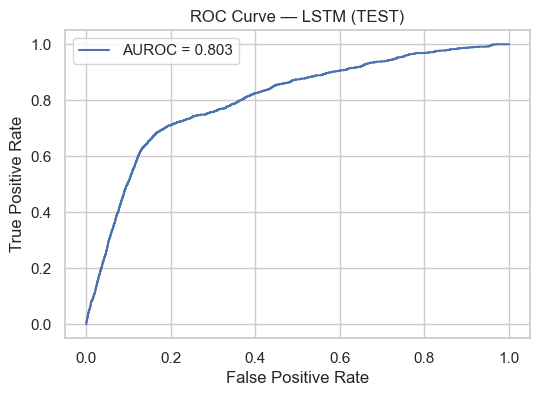

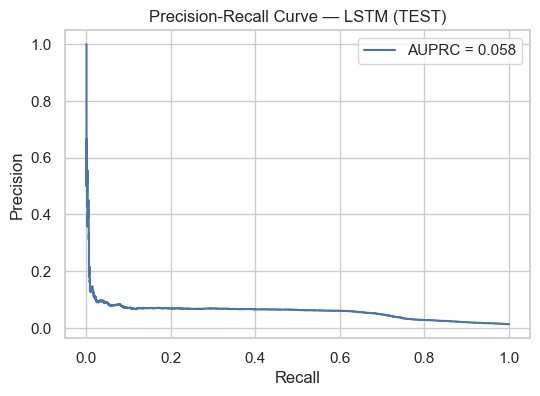

In [32]:
val_loss, val_auroc, val_auprc, val_f1, val_acc = run_epoch(lstm_model, val_loader, train=False)
test_loss, test_auroc, test_auprc, test_f1, test_acc = run_epoch(lstm_model, test_loader, train=False)

print("\n[VAL — LSTM]")
print(f"loss : {val_loss:.4f}")
print(f"AUROC: {val_auroc:.4f}")
print(f"AUPRC: {val_auprc:.4f}")
print(f"F1   : {val_f1:.4f}")
print(f"ACC  : {val_acc:.4f}")

print("\n[TEST — LSTM]")
print(f"loss : {test_loss:.4f}")
print(f"AUROC: {test_auroc:.4f}")
print(f"AUPRC: {test_auprc:.4f}")
print(f"F1   : {test_f1:.4f}")
print(f"ACC  : {test_acc:.4f}")

# Store LSTM metrics for comparison
lstm_val_loss, lstm_val_auroc, lstm_val_auprc, lstm_val_f1, lstm_val_acc = (
    val_loss, val_auroc, val_auprc, val_f1, val_acc
)
lstm_test_loss, lstm_test_auroc, lstm_test_auprc, lstm_test_f1, lstm_test_acc = (
    test_loss, test_auroc, test_auprc, test_f1, test_acc
)

# ROC & PR on TEST
lstm_test_probs, lstm_test_targets = predict_loader(lstm_model, test_loader)

fig, ax = plt.subplots(figsize=(6, 4))
fpr_l, tpr_l, _ = metrics.roc_curve(lstm_test_targets, lstm_test_probs)
ax.plot(fpr_l, tpr_l, label=f"AUROC = {lstm_test_auroc:.3f}")
ax.set_title("ROC Curve — LSTM (TEST)")
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.legend()
EXPORTED_FIGURES.append(("05_lstm_roc_test", fig))
plt.show()

fig, ax = plt.subplots(figsize=(6, 4))
precision_l, recall_l, _ = metrics.precision_recall_curve(lstm_test_targets, lstm_test_probs)
ax.plot(recall_l, precision_l, label=f"AUPRC = {lstm_test_auprc:.3f}")
ax.set_title("Precision-Recall Curve — LSTM (TEST)")
ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
ax.legend()
EXPORTED_FIGURES.append(("05_lstm_pr_test", fig))
plt.show()

## Step 14 — Export LSTM per-hour risk trajectories (train/val/test)

In [33]:
# Use the same predict_loader helper
lstm_train_probs, lstm_train_targets = predict_loader(lstm_model, train_loader)
lstm_val_probs, lstm_val_targets = predict_loader(lstm_model, val_loader)
lstm_test_probs, lstm_test_targets = predict_loader(lstm_model, test_loader)


def build_lstm_traj_df(
        index_list: list[tuple[int, int]],
        probs: np.ndarray,
        split_name: str,
) -> pd.DataFrame:
    rows = []
    for (pid, end_idx), p in zip(index_list, probs):
        times = patient_data[pid]["times"]
        time = int(times[end_idx])

        sepsis = int(key_df.loc[(pid, time), TARGET_COL])
        label_6h = int(key_df.loc[(pid, time), LABEL_COL])

        rows.append({
            PATIENT_COL: pid,
            TIME_COL: time,
            TARGET_COL: sepsis,
            LABEL_COL: label_6h,
            "risk_lstm_seq": float(p),
            "split_05": split_name,
        })
    return pd.DataFrame(rows)


lstm_train_traj_df = build_lstm_traj_df(train_index, lstm_train_probs, "train")
lstm_val_traj_df = build_lstm_traj_df(val_index, lstm_val_probs, "val")
lstm_test_traj_df = build_lstm_traj_df(test_index, lstm_test_probs, "test")

lstm_trainval_traj_df = pd.concat([lstm_train_traj_df, lstm_val_traj_df], axis=0, ignore_index=True)

lstm_trainval_traj_path = RESULTS_THIS / "05_lstm_risk_trajectories_trainval.csv"
lstm_test_traj_path = RESULTS_THIS / "05_lstm_risk_trajectories_test.csv"

lstm_trainval_traj_df.to_csv(lstm_trainval_traj_path, index=False)
lstm_test_traj_df.to_csv(lstm_test_traj_path, index=False)

print("Saved LSTM risk trajectories to:")
print("  train/val:", lstm_trainval_traj_path)
print("  test     :", lstm_test_traj_path)
print("\nExample rows:")
display(lstm_trainval_traj_df.head())


Saved LSTM risk trajectories to:
  train/val: C:\Users\marta\PyCharmMiscProject\sepsis-predictor\reports\results\05_sequence_models\05_lstm_risk_trajectories_trainval.csv
  test     : C:\Users\marta\PyCharmMiscProject\sepsis-predictor\reports\results\05_sequence_models\05_lstm_risk_trajectories_test.csv

Example rows:


,Patient_ID,ICULOS,SepsisLabel,Label_6h,risk_lstm_seq,split_05
0,1,24,0,0,0.031518,train
1,1,25,0,0,0.393214,train
2,1,26,0,0,0.101818,train
3,1,27,0,0,0.049623,train
4,1,28,0,0,0.112537,train


## Step 15 — Save GRU & LSTM metrics summary and export figures

In [34]:
metrics_summary = pd.DataFrame([
    {
        "model": "gru_sequence",
        "val_loss": gru_val_loss,
        "val_auroc": gru_val_auroc,
        "val_auprc": gru_val_auprc,
        "val_f1": gru_val_f1,
        "val_acc": gru_val_acc,
        "test_loss": gru_test_loss,
        "test_auroc": gru_test_auroc,
        "test_auprc": gru_test_auprc,
        "test_f1": gru_test_f1,
        "test_acc": gru_test_acc,
    },
    {
        "model": "lstm_sequence",
        "val_loss": lstm_val_loss,
        "val_auroc": lstm_val_auroc,
        "val_auprc": lstm_val_auprc,
        "val_f1": lstm_val_f1,
        "val_acc": lstm_val_acc,
        "test_loss": lstm_test_loss,
        "test_auroc": lstm_test_auroc,
        "test_auprc": lstm_test_auprc,
        "test_f1": lstm_test_f1,
        "test_acc": lstm_test_acc,
    },
])

metrics_path = RESULTS_THIS / "05_sequence_model_metrics.csv"
metrics_summary.to_csv(metrics_path, index=False)
print("Saved GRU/LSTM sequence model metrics to:", metrics_path)

# Export all collected figures (GRU + LSTM)
for name, fig in EXPORTED_FIGURES:
    out_path = FIGURES_THIS / f"{name}.png"
    fig.savefig(out_path, dpi=300, bbox_inches="tight")
    print("Saved figure:", out_path)

print("\nAll sequence model figures successfully exported.")

Saved GRU/LSTM sequence model metrics to: C:\Users\marta\PyCharmMiscProject\sepsis-predictor\reports\results\05_sequence_models\05_sequence_model_metrics.csv
Saved figure: C:\Users\marta\PyCharmMiscProject\sepsis-predictor\reports\figures\05_sequence_models\05_gru_roc_test.png
Saved figure: C:\Users\marta\PyCharmMiscProject\sepsis-predictor\reports\figures\05_sequence_models\05_gru_pr_test.png
Saved figure: C:\Users\marta\PyCharmMiscProject\sepsis-predictor\reports\figures\05_sequence_models\05_lstm_roc_test.png
Saved figure: C:\Users\marta\PyCharmMiscProject\sepsis-predictor\reports\figures\05_sequence_models\05_lstm_pr_test.png

All sequence model figures successfully exported.
